# load numerical model (Anne M) and inspect

In [1]:
import os
from glob import glob

%matplotlib inline
import matplotlib.pyplot as plt
import cmocean.cm as cm

import numpy as np
import pandas as pd
import xarray as xr

import xgcm

from tqdm import tqdm

# cognac data and tools
#import cognac.insitu as iu
#import pynsitu as pin

----

## load data

To be done on datarmor.
Copy extracted netcdf file back on laptop.

In [ ]:
root_dir = "/home/datawork-lops-osi/equinox/das"

In [4]:
# load das coordinates
nc = os.path.join(root_dir, "common/coords_toulon.nc")
das = xr.open_dataset(nc)

In [6]:
# load model grid
grid_nc = os.path.join(root_dir, "model_mio/gridT.nc")
grid = xr.open_dataset(grid_nc)
grid = grid.rename(**{"X200_299": "x", "Y110_179": "y", "Z":"depth",
                      "MBATHY": "bottom", "NAV_LON": "lon", "NAV_LAT": "lat",
                     } )
grid = (grid
        .set_index(depth="NAV_LEV")
        .set_coords(["lon", "lat"])
        .squeeze()
       )
grid = grid.assign_coords(h=grid.depth.isel(depth=grid.bottom).drop("depth"))

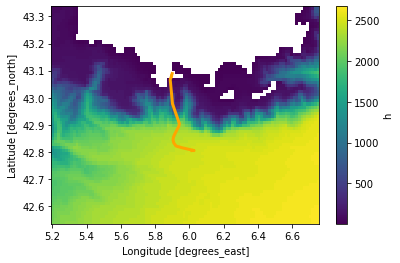

In [10]:
fig, ax = plt.subplots(1,1)
grid.h.where(grid.h>1).plot(x="lon", y="lat")
ax.plot(das.longitude, das.latitude, color="orange", lw=3)

In [19]:
# load data
def preprocess(ds):
    ds = ds.rename(**{"X200_299": "x", "Y110_179": "y", "DEPTHT":"depth",
                      "TIME_COUNTER": "time", 
                      "DEPTHT_bnds": "z_bounds",
                      "VOTEMPER": "temperature",
                     } 
                  )
    return ds
    
nc_files = sorted(glob(os.path.join(root_dir, "model_mio/Temp_*.nc")))
ds = xr.open_mfdataset(nc_files, preprocess=preprocess, concat_dim="time", combine="nested")
ds = ds.assign_coords(**grid)

---

## maps

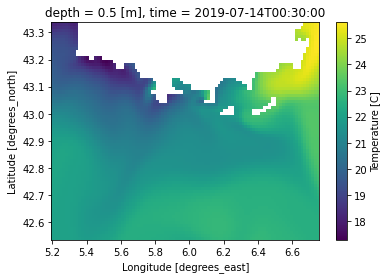

In [22]:
# surface

da = ds.temperature.isel(depth=0)

fig, ax = plt.subplots(1,1)
da.isel(time=0).plot(x="lon", y="lat", ax=ax)

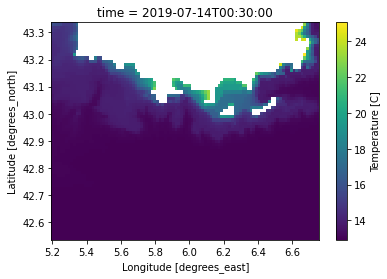

In [40]:
# bottom
ds["temperature_bottom"] = ds.temperature.isel(depth=ds.bottom-1)
ds["temperature_bottom_mean"] = ds["temperature_bottom"].mean("time")


da = ds.temperature_bottom.isel(time=0)

fig, ax = plt.subplots(1,1)
da.plot(x="lon", y="lat", ax=ax)

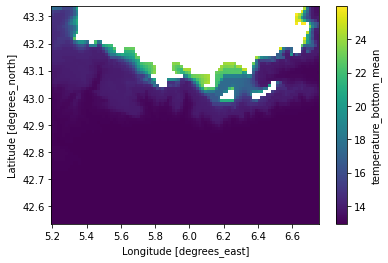

In [41]:
# bottom: mean

da = ds.temperature_bottom_mean

fig, ax = plt.subplots(1,1)
da.plot(x="lon", y="lat", ax=ax)

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'ls'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


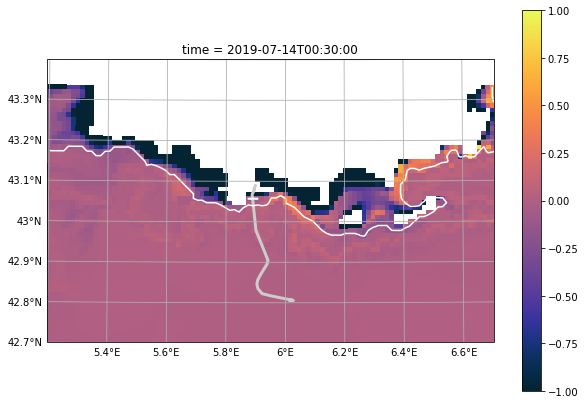

In [90]:
# bottom anomaly

da = (ds.temperature_bottom - ds.temperature_bottom_mean).isel(time=0)

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo


def plot_map(da, figsize=(10,7), **kwargs):

    #fig, ax = plt.subplots(1,1)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection=ccrs.Orthographic(6, 43.))

    da.plot(x="lon", y="lat", ax=ax, transform=ccrs.PlateCarree(), **kwargs)
    ax.set_extent([5.2, 6.7, 42.7, 43.4])

    gl = ax.gridlines(draw_labels=True, dms=False,
                      x_inline=False, y_inline=False,
                    )
    gl.right_labels=False
    gl.top_labels=False    
    
    #dland = dict(scale="110m", edgecolor='face', facecolor=cfeature.COLORS['land'])
    #land_feature = cfeature.NaturalEarthFeature('physical', 'land', **dland)
    #ax.add_feature(land_feature,  zorder=0)    
    ax.plot(das.longitude, das.latitude, color="0.8", lw=3, transform=ccrs.PlateCarree(),)

    da.h.plot.contour(x="lon", y="lat", levels=[100], colors="w", ls="--",
                      transform=ccrs.PlateCarree())
    
    return fig

plot_map(da, vmin=-1, vmax=1, cmap=cm.thermal, extend="neither");

In [92]:
da = (ds.temperature_bottom - ds.temperature_bottom_mean).compute()

In [84]:

plt.switch_backend("agg")

i=0
for t in tqdm(da.time):
    _da = da.sel(time=t)
    fig = plot_map(_da, vmin=-1, vmax=1, cmap=cm.thermal, extend="neither")
    savefig = os.path.join(os.environ["SCRATCH"], f"figs/mio_{i:03d}.png")
    fig.savefig(savefig, dpi=150, bbox_inches = "tight")
    plt.close(fig)
    i+=1


100%|██████████| 432/432 [03:31<00:00,  2.04it/s]


/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'ls'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


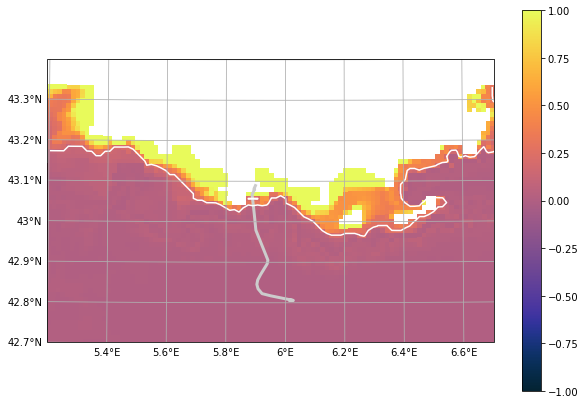

In [93]:
_da = da.std("time")

plot_map(_da, vmin=-1, vmax=1, cmap=cm.thermal, extend="neither");

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'ls'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


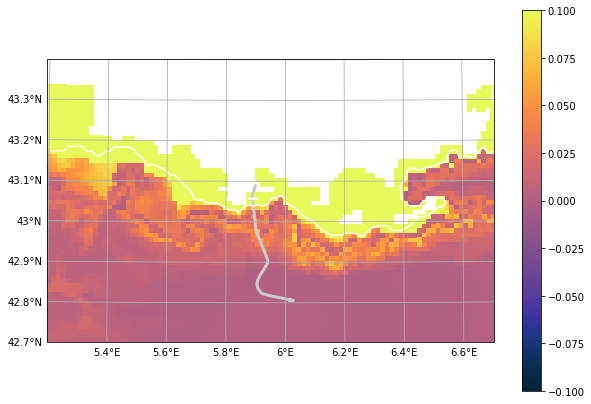

In [94]:
_da = da.std("time")

plot_map(_da, vmin=-.1, vmax=.1, cmap=cm.thermal, extend="neither");

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'ls'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


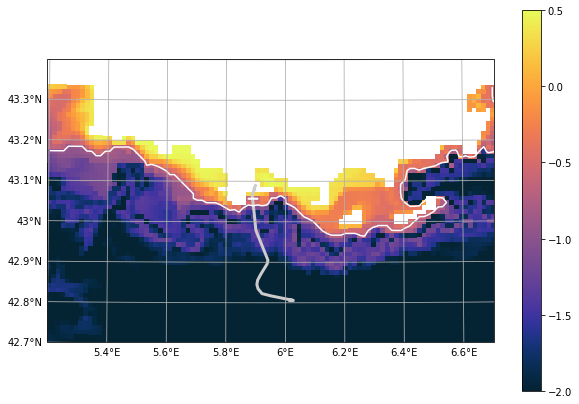

In [97]:
_da = np.log10(da.std("time"))

plot_map(_da, vmin=-2, vmax=0.5, cmap=cm.thermal, extend="neither");

---

## rapide overview over straight transect

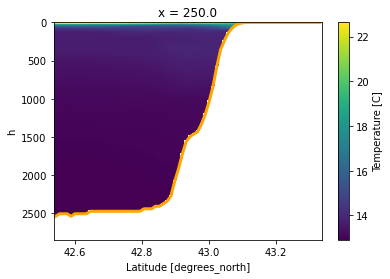

In [20]:
da = ds.temperature.isel(x=50)

fig, ax = plt.subplots(1,1)
da.isel(time=0).plot(x="lat", y="depth", ax=ax)

da.h.plot(x="lat", color="orange", lw=3)

ax.invert_yaxis()

In [ ]:
_da = da.isel(depth=da.bottom-1)

_da.plot(x="time")

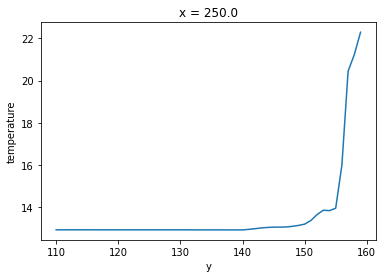

In [114]:
_da.mean("time").plot()

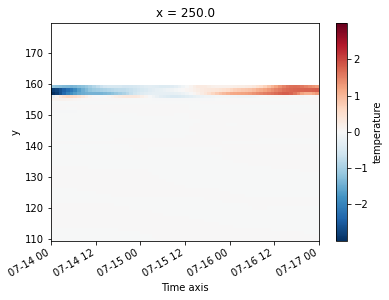

In [113]:
(_da-_da.mean("time")).plot(x="time")

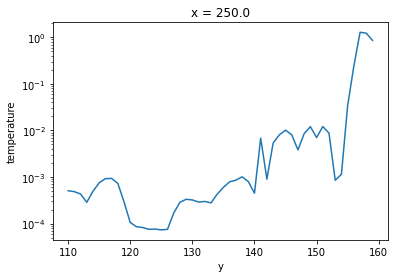

In [117]:
(_da-_da.mean("time")).std("time").plot(yscale="log")

### store data